In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sl = 70 #sequence_length
n_latent = 8
perplexity = 30

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
import numpy as np
from myfunctions import action_to_group, get_group_labels, read_data, read_config, num_to_idx 

directory_dataset = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/data_nathan/'

directory = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/grouping_0/'
with open(directory + 'name_of_labels_original.txt') as f:
    name_labels = [word for line in f for word in line.split()]

feat_size = 63 #21 joints * 3 dimensions (xyz)
batch_size = 20
padding_size = 300

# Parameters
learning_rate = 0.003
n_epochs = 200

# Network Parameters
seq_max_len = padding_size # Sequence max length
n_hidden = 100 # hidden layer num of features
p_dropout = 0.5

In [3]:
#Called to load training/testing data 
def create_dataset(filename, group_number):
    # dataset is organized as NxLxD (N = num samples, L temporal length with padding, D feature dimension
    # labels is NxY where Y is one hot label vector
    
    # -3 sends back labels as actions number (0..45) with one hot enconding (000..1..00)
    # -2 sends back labels as actions number (0..45) with no one hot enconding (1 or 2 or 45)
    # -1 sends back labels as groups number (0..12or26) with one hot encoding (000..1..00)
    # 0> sends back labels of only this group with one hot enconding

    dataset, labels, lengths = [], [], []
    files = read_config(filename)
    
    if group_number == -3: #standard 45 actions RNN
        num_classes = 45
    elif group_number == -2: #groupRNN to subnets (testing phase)
        #num_classes = 45 #not needed in the function when -2 activated
        pass
    elif group_number == -1: #groupRNN
        num_classes = max(atog) + 1 
        #pass
    else: #subnets
        list_actions = gtoa[group_number] #gives list of actions in current group number
        num_classes = len(list_actions)
        
    for i in files:
        
        if group_number == -3:  #standard 45 actions RNN
            
            tmp_data = read_data(directory_dataset + i[0]) #i[0] =  a01s01r01.txt (for eg)
            num =  int( i[1] )
            tmp_labels = np.transpose(num_to_idx(num, num_classes)) #one hot encoding
        
        elif group_number == -2: #Feed output of groupRNN to pre-trained subnet (testing phase)
            
            tmp_data = read_data(directory_dataset + i[0]) #i[0] =  a01s01r01.txt (for eg)
            tmp_labels = int(i[1]) #will one hot later as first need to dispatch data to relevant subnet using labels
        
        elif group_number == -1: #Build groupRNN
            
            tmp_data = read_data(directory_dataset + i[0]) 
            num =  atog[ int( i[1] )] #only used for one hot encoding in the line below
            tmp_labels = np.transpose(num_to_idx(num, num_classes)) 
            #i[0] =  a01s01r01.txt (for eg)
            #i[1] = number between 0 and 44 (or as many classes there is)
            #tmp_labels = [0, 0, 1, 0, .. 0] = one-hot encoding of class value
            #tmp_data = list with variable len around 300 & each item in the list is a nested list of len 63 (=feat_size)
        
        else: #Build subnet RNN
            
            num = int( i[1] ) #original action number
            if num in list_actions: #select data only if belongs to group 
                tmp_data = read_data(directory_dataset + i[0]) #add to dataset if part of the group
                tmp_labels = np.transpose(num_to_idx(list_actions.index(num), num_classes)) #add labels as well     
            else: continue
            
        if len(tmp_data)<300: #why 300, is that the longest sequence ? 300 = padding_size btw...
            
            #records tmp_data initial length before padding
            #pads tmp_data with zeros until padding_size (300) so len(tmp_data) = 300 always with len 63 items
                
            lengths.append(len(tmp_data))
            tmp_data.extend([ [0.0] * feat_size ] * (padding_size - len(tmp_data)))  

            dataset.append(tmp_data)
            labels.append(tmp_labels) 
        
    # all 0..565 lists with item as nested lists of size (300, 26, 1)
    
    return np.asarray(dataset), np.asarray(labels), np.asarray(lengths,dtype=np.int32)

#Called once when training RNN
def batch_generation(data,labels,lengths):
    
    num_classes = np.size(labels,1) #labels is a one hot encoded numpy array. This returns number of columns (=groups).
    
    nsamples,_,_ = data.shape

    indices = np.arange(nsamples) #np.arange(3) -> array([0, 1, 2])
    np.random.shuffle(indices) #shuffle the indices
    num_batches = int(np.floor(nsamples/batch_size)) #round to inferior number so = 0 if batch_size bigger than nsamples
    not_exact = 0

    if nsamples%batch_size != 0: #happens all the time unless nsamples is lucky multiple of batch_size
        not_exact = 1
    
    #declare empty arrays to contain the batches, dimensions are right
    batches_data = np.empty(shape=[num_batches+not_exact,batch_size,padding_size,feat_size])
    batches_labels = np.empty(shape=[num_batches+not_exact,batch_size,num_classes]) 
    batches_lengths = np.empty(shape=[num_batches + not_exact, batch_size],dtype=np.int32)

    for x in range(num_batches):
        batches_data[x, :, :, :] = data[indices[batch_size*x:batch_size*(x+1)], :, :]
        batches_labels[x,:,:] = labels[indices[batch_size*x:batch_size*(x+1)], :]
        batches_lengths[x,:] = lengths[indices[batch_size*x:batch_size*(x+1)]]

    if not_exact > 0:
        
        to_complete = nsamples%batch_size
        
        #nsamples is too small, reuse the samples from previous batch, taken randomly to complete this batch
        tmp_random = np.random.randint(0,nsamples,batch_size-to_complete) # we complete last batch with random samples
        #prints list of indices it will take randomly
        
        #[num_batches] refers to the last batch that is not complete
        tmp_data = data[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:,:]
        batches_data[num_batches]=np.concatenate((tmp_data,data[tmp_random,:,:]),axis=0)

        tmp_labels = labels[indices[batch_size*num_batches:batch_size*num_batches+to_complete],:]
        batches_labels[num_batches] = np.concatenate((tmp_labels,labels[indices[tmp_random],:]))
        
        tmp_lengths = lengths[indices[batch_size*num_batches:batch_size*num_batches+to_complete]]
        batches_lengths[num_batches] = np.concatenate((tmp_lengths,lengths[indices[tmp_random]]))

    return batches_data, batches_labels, batches_lengths, num_batches+not_exact

In [4]:
tf.reset_default_graph()

batch_size = 20

X_in = tf.placeholder(dtype=tf.float32, shape=[None, sl, 63], name='X') #here
Y    = tf.placeholder(dtype=tf.float32, shape=[None, sl, 63], name='Y') #here
Y_flat = tf.reshape(Y, shape=[-1, sl * 63]) #here
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2


def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [5]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, sl, 63, 1]) #here
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

In [6]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=sl* 63, activation=tf.nn.sigmoid) #here
        img = tf.reshape(x, shape=[-1, sl, 63]) #here
        return img

In [7]:
sampled, mn, sd = encoder(X_in, keep_prob) #sampled is the z value
dec = decoder(sampled, keep_prob)

unreshaped = tf.reshape(dec, [-1, sl*63]) #here

img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)

optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
train_data, train_labels, train_lengths = create_dataset('training.txt', -3)
true_labels = np.asarray( [ np.where(r==1)[0][0] for r in train_labels ], dtype=np.int64) #one hot to action number
train_data = np.asarray(train_data)
train_labels = np.asarray(train_labels)
train_lengths = np.asarray(train_lengths)

test_data, test_labels, test_lengths = create_dataset('testing.txt', -3)
test_labels = np.asarray( [ np.where(r==1)[0][0] for r in test_labels ], dtype=np.int64) #one hot to action number
test_data = np.asarray(test_data)
test_labels = np.asarray(test_labels)
test_lengths = np.asarray(test_lengths)

(batch_x, batch_y, batch_seqlen, n_batches) = batch_generation(train_data, train_labels, train_lengths)

batch_x = batch_x[:,:,:sl,:]

print('batch_x.shape', batch_x.shape)

('batch_x.shape', (30, 20, 70, 63))


In [9]:
def displayForMe(a,b, c):

    ax = plt.subplot(1, 2, 1)
    ax.set_title("Original " + str(c))
    plt.imshow(a, cmap='gray')
    
    #b[b < 0.01] *= 100
    
    ax = plt.subplot(1, 2, 2)
    ax.set_title("Decoded " + c)
    plt.imshow(b, cmap='gray')

    plt.show()
    
def doTSNE(X, y): #doTSNE(z, labels)

    from sklearn import datasets
    from sklearn.manifold import TSNE
    from matplotlib import pyplot as plt
    import randomcolor

    #digits = datasets.load_digits()
    # Take the first 500 data points: it's hard to see 1500 points
    #X = digits.data[:500]
    #y = digits.target[:500]

    tsne = TSNE(n_components=2, random_state=0,  perplexity=perplexity)
    X_2d = tsne.fit_transform(X)
    
    target_ids = range(len(name_labels))
    
    #colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
    #colors = randomcolor.RandomColor().generate(count=len(name_labels))
    colors = ['#5fdda2', '#b68fd8', '#924fbc', '#cd89e5', '#edffaf', '#ccedff',
              '#6cd86f', '#3a8dc1', '#13d343', '#fca105', '#7ae8cc', '#d341af', 
              '#2b90d8', '#d12d1b', '#e5e37e', '#f9ad84', '#eda371', '#d1a570', 
              '#915251', '#4412a8', '#5c359e', '#0cad8a', '#1ebcaa', '#a179ce', 
              '#6c52c9', '#0f991d', '#e8772c', '#574bf4', '#e84762', '#fcf8ab', 
              '#70d39e', '#a3bc01', '#caed93', '#d99aed', '#dd77d8', '#4bd15a', 
              '#dda58b', '#f2a4e2', '#f7b2c6', '#24ada1', '#f79f2c', '#929cf4', 
              '#230b7a', '#37efc4', '#778bef']
    '''
    colors = ['#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2',
              '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2',
              '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2',
              '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2',
              '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2',
              '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2',
              '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2', '#5fdda2',
              '#5fdda2', '#ffe119','#0082c8']
    '''
    
    #plt.figure(figsize=(6, 5))
    
    for i, c, label in zip(target_ids, colors, name_labels):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
    
    #print('TSNE on ' + str(np.max(y)+1) + ' actions with n_latent at ' + str(n_latent))
    #plt.legend()
    plt.show()

In [10]:
# try tsne on only 10 actions to see if patterns come out better
# change n_latent for other embedding size -> try n_latent = 4 and 16 -> not better
# change tsne perplexity -> try at 10 and 50 -> not better -> still a cloud of points = noise
# n_latent = 2 -> visualise in 2D -> algo high loss, cant reconstruct image properly
# Improve tsne
# improve reducing loss
# Move on and just try the embedding directly.


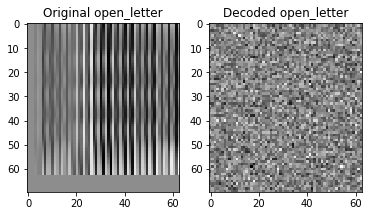

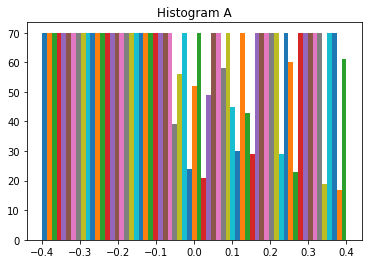

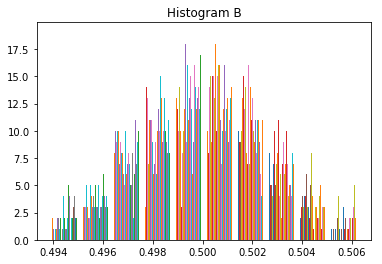

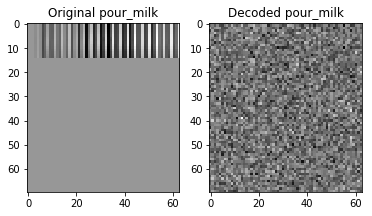

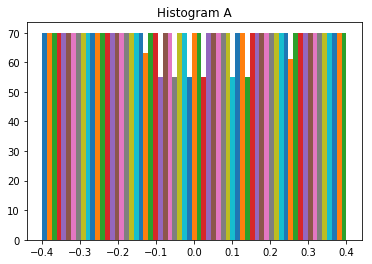

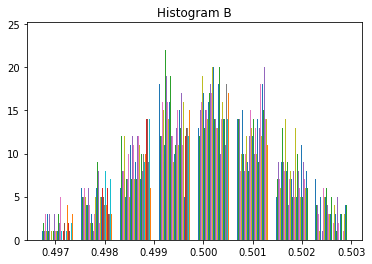

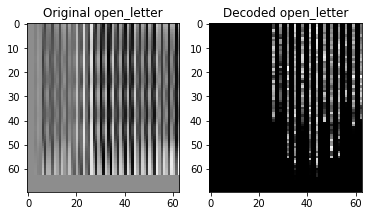

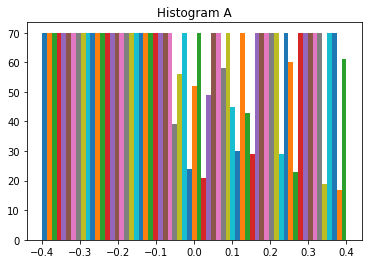

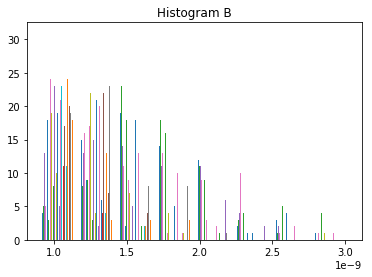

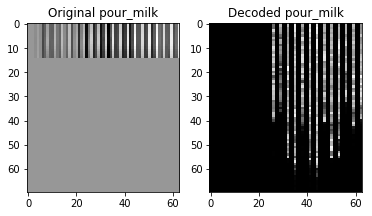

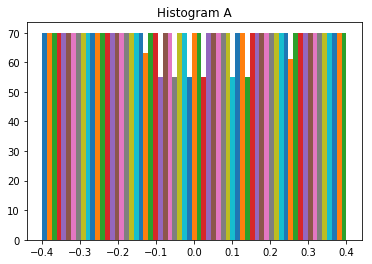

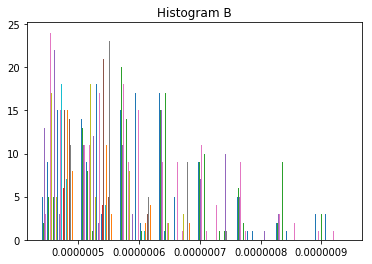

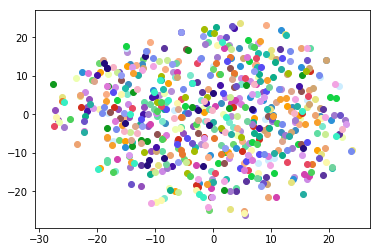

('Epoch', 1, 'loss', 286.74176, 'image loss', 285.12598, 'latent_loss', 1.6157837)


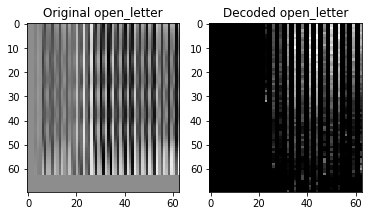

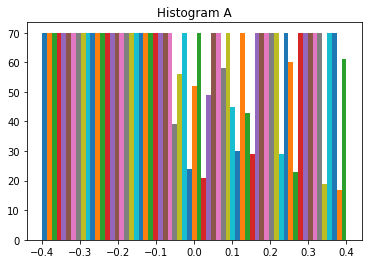

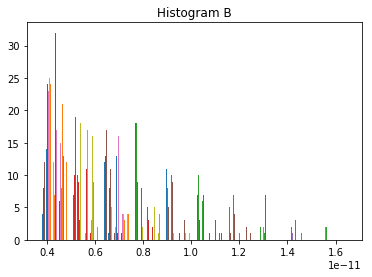

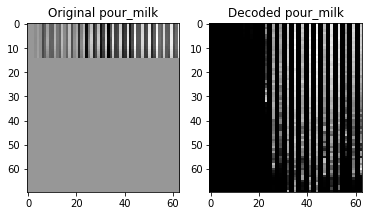

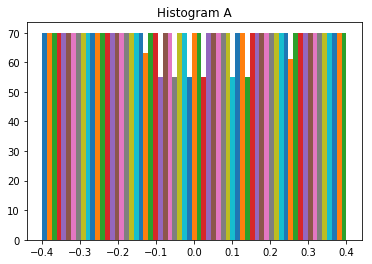

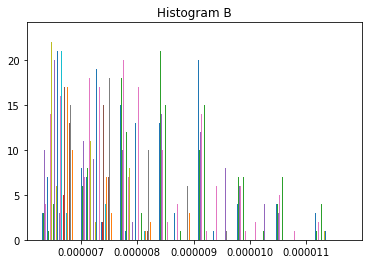

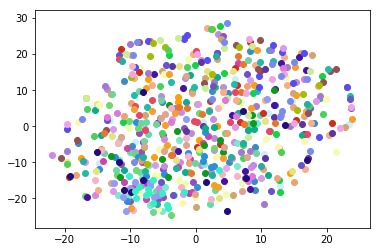

('Epoch', 2, 'loss', 256.5173, 'image loss', 254.02275, 'latent_loss', 2.494557)


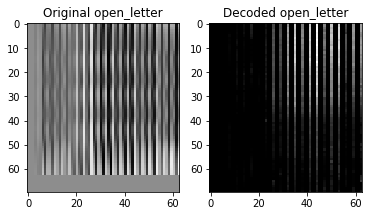

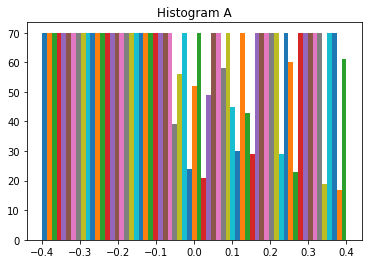

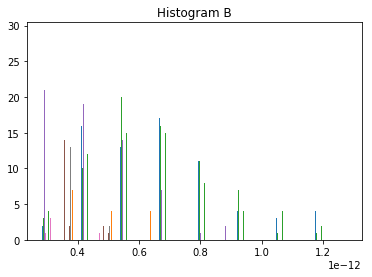

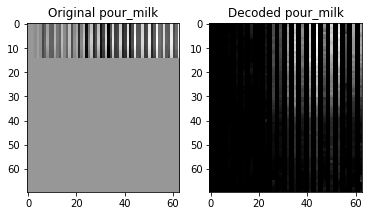

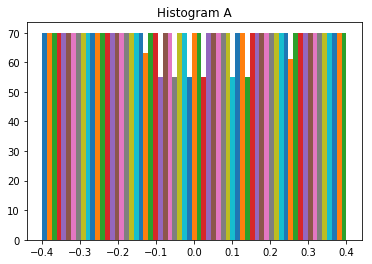

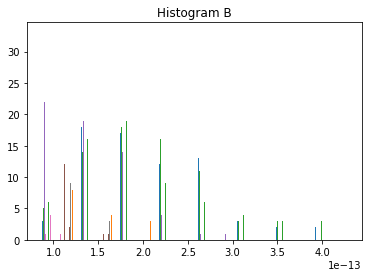

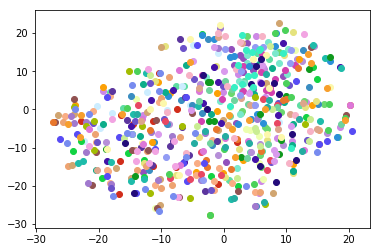

('Epoch', 3, 'loss', 240.50516, 'image loss', 238.37817, 'latent_loss', 2.1269698)


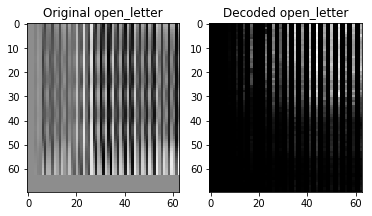

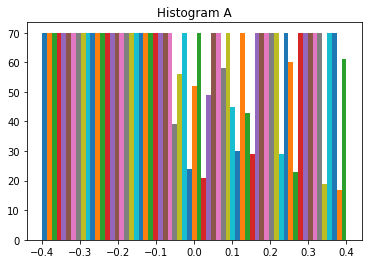

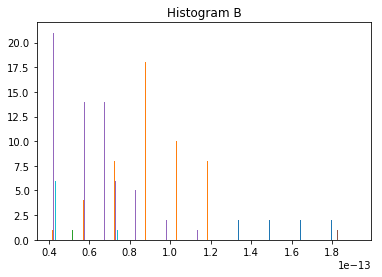

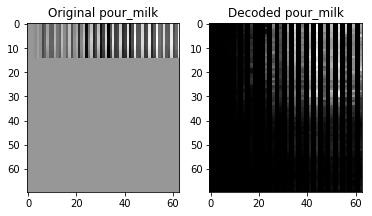

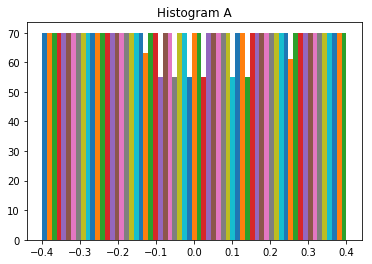

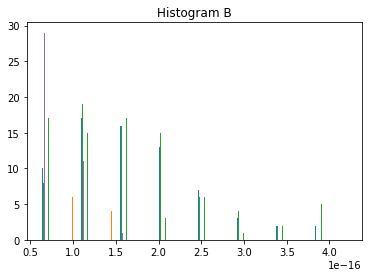

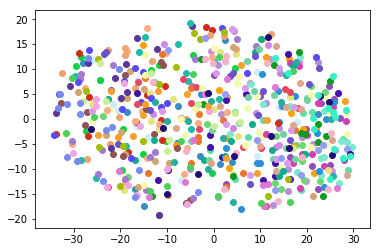

('Epoch', 4, 'loss', 237.25656, 'image loss', 234.45866, 'latent_loss', 2.7978954)


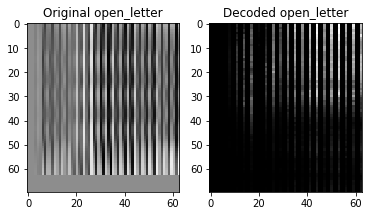

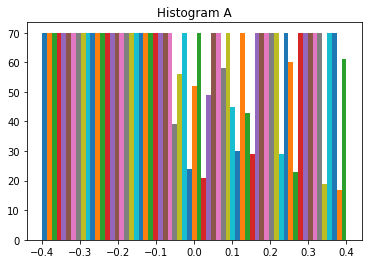

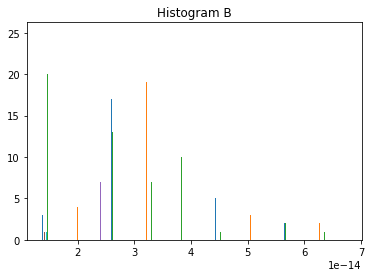

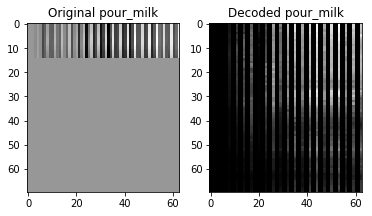

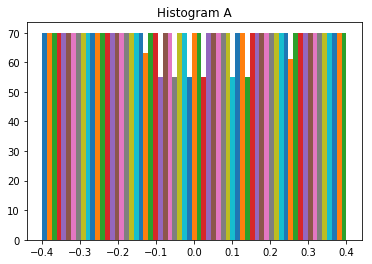

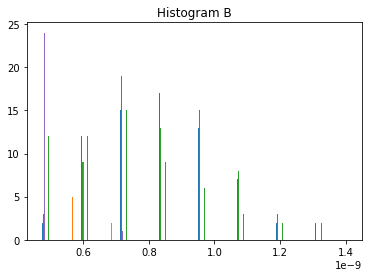

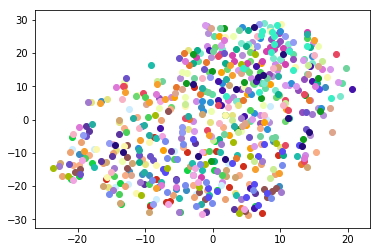

('Epoch', 5, 'loss', 237.23523, 'image loss', 234.66609, 'latent_loss', 2.5691216)


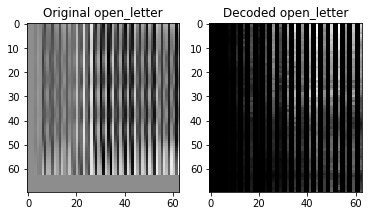

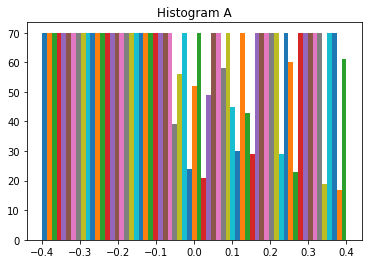

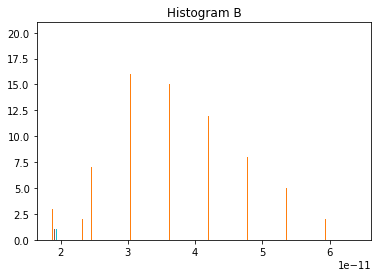

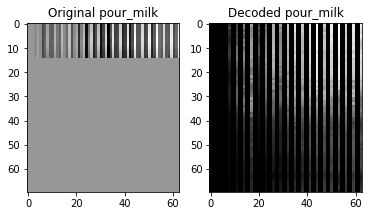

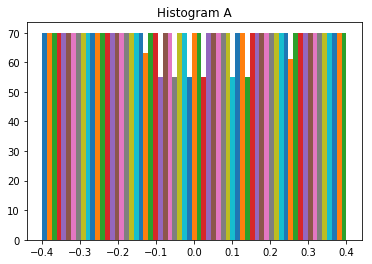

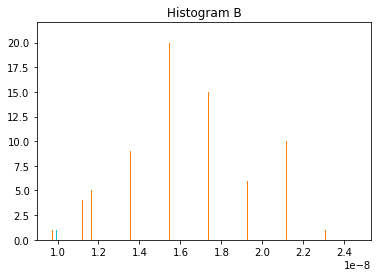

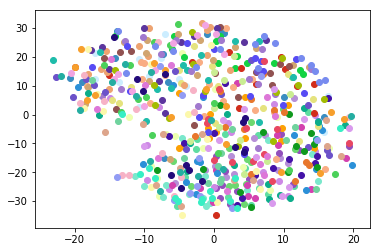

('Epoch', 6, 'loss', 235.58159, 'image loss', 232.58249, 'latent_loss', 2.9991388)


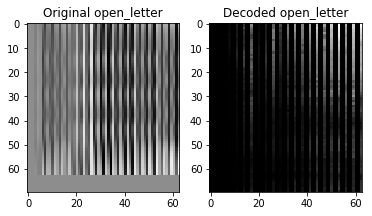

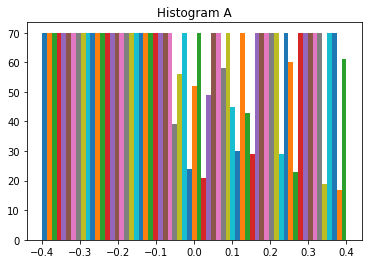

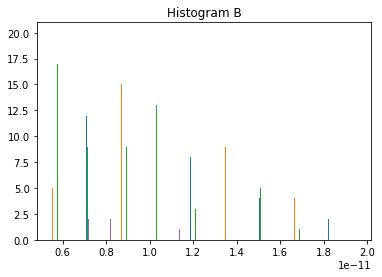

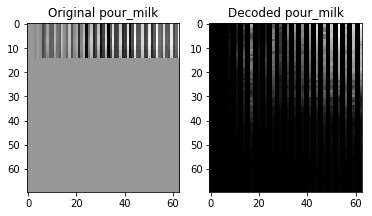

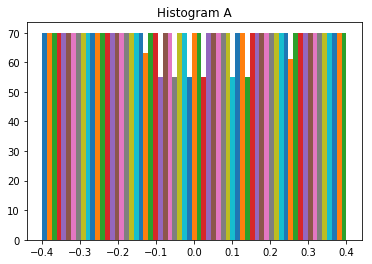

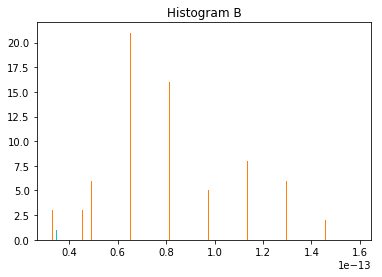

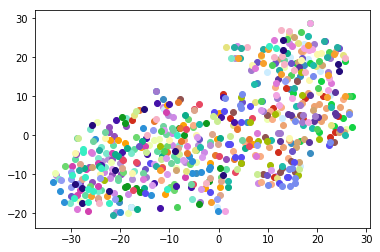

('Epoch', 7, 'loss', 229.55623, 'image loss', 225.72786, 'latent_loss', 3.8283715)


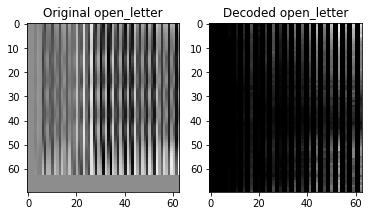

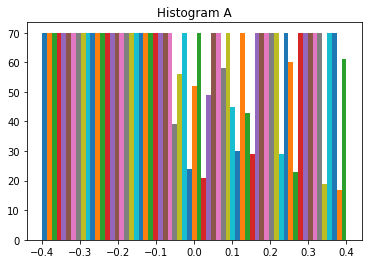

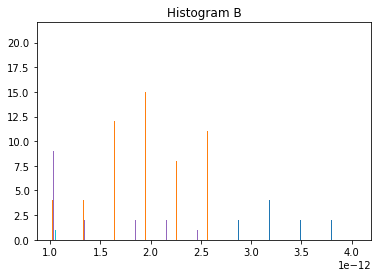

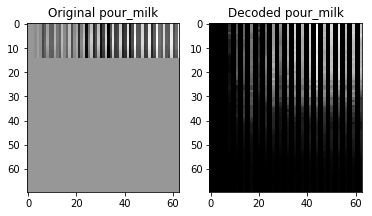

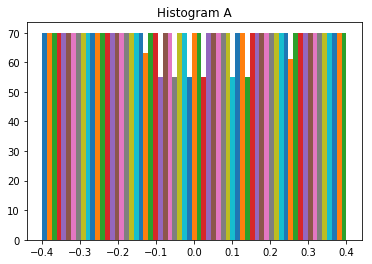

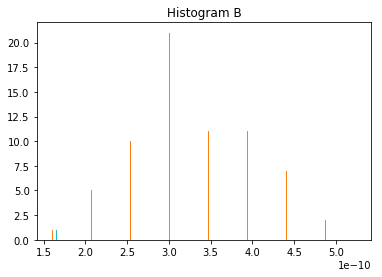

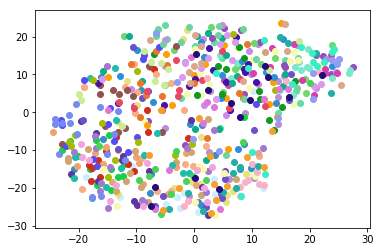

('Epoch', 8, 'loss', 228.87598, 'image loss', 224.6364, 'latent_loss', 4.239563)


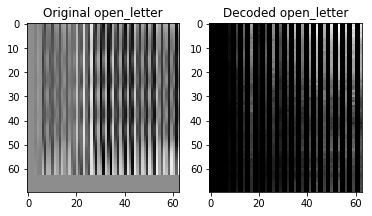

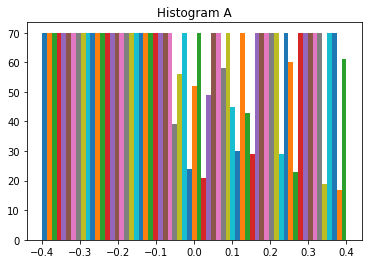

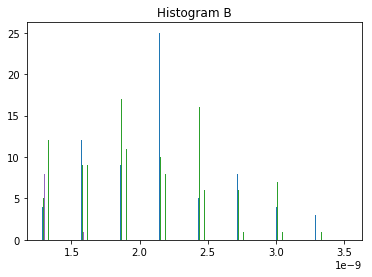

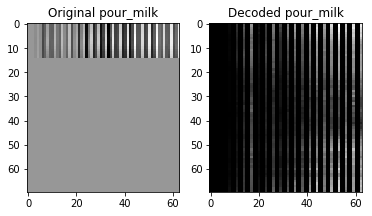

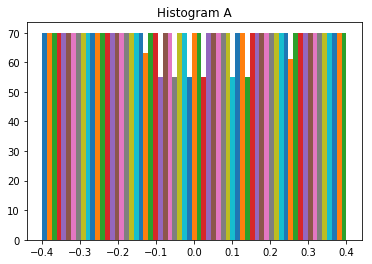

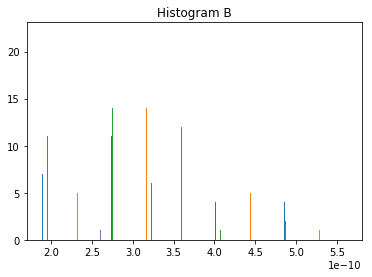

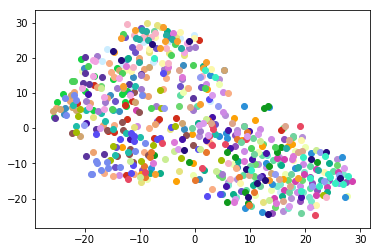

('Epoch', 9, 'loss', 228.1211, 'image loss', 223.77177, 'latent_loss', 4.34928)


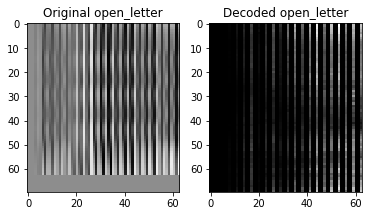

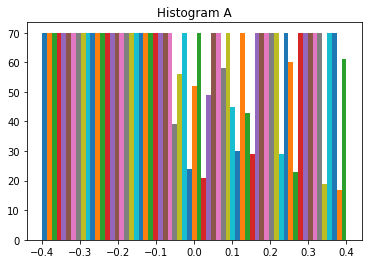

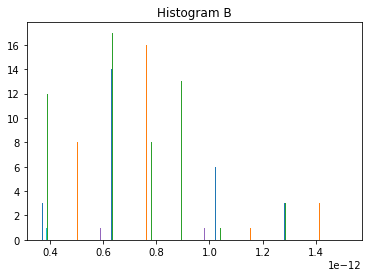

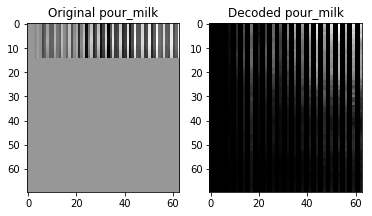

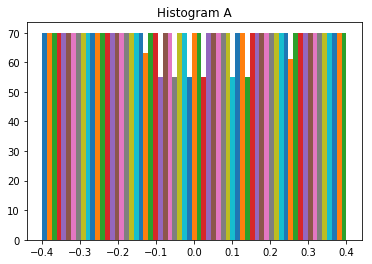

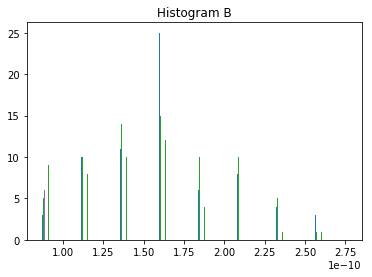

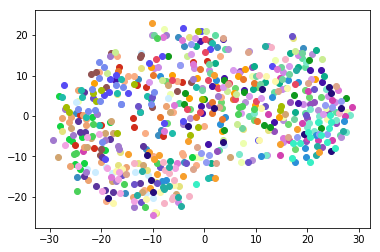

('Epoch', 10, 'loss', 227.64297, 'image loss', 223.26363, 'latent_loss', 4.3793497)


In [11]:
l = np.zeros(10)
j = 0 #between 0 and 28

for k in range(10): #epochs
    
    if k == 0 :
        #################
        batch = batch_x[29]
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        l[k] = ls

        index = np.nonzero(batch_y[29][j])[0][0]
        displayForMe(batch[j], d[j], name_labels[index])
        index2 = np.nonzero(batch_y[29][j+1])[0][0]
        displayForMe(batch[j+1], d[j+1], name_labels[index2]) #just a second image
        ################

    for i in range(30): #30 for training set | 29 for testing
        
        batch = batch_x[i]
        batchy = batch_y[i]
        
        #batch = [np.reshape(b, [sl, 63]) for b in mnist.train.next_batch(batch_size=batch_size)[0]] #here
        sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})

    #at every epoch end
    ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
    l[k] = ls
    
    index = np.nonzero(batchy[j])[0][0]
    displayForMe(batch[j], d[j], name_labels[index])
    index2 = np.nonzero(batchy[j+1])[0][0]
    displayForMe(batch[j+1], d[j+1], name_labels[index2]) #just a second image
    
    #Generate the embedding when VAE optimised on the last epoch
    z = sess.run([sampled], feed_dict = {X_in: train_data[:,:sl,:], Y: train_data[:,:sl,:], keep_prob: 1.0})
    z_test = sess.run([sampled], feed_dict = {X_in: test_data[:,:sl,:], Y: test_data[:,:sl,:], keep_prob: 1.0})
    z = z[0] # z is (595,8)
    z_test = z_test[0]
    
    #Cant see TSNE on 45 classes, need to limit to 5 classes
    #TSNE on z
    idx = true_labels < 45
    sel_true_labels = true_labels[ idx ]
    sel_z = z[ idx ]
    #TSNE on z_test
    #idx = test_labels < 45
    #sel_true_labels = test_labels[ idx ]
    #sel_z = z_test[ idx ]
    doTSNE(sel_z, sel_true_labels) #doTSNE(z, true_labels)
    
    print('Epoch', k+1, 'loss', ls, 'image loss', np.mean(i_ls), 'latent_loss', np.mean(d_ls))
    

** Plot loss **

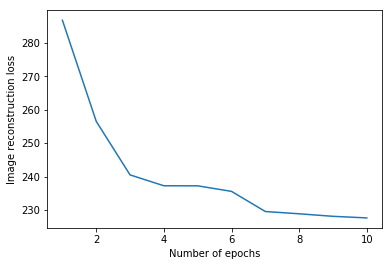

In [12]:
#plot loss

plt.plot(range(1, np.size(l)+1), l)
plt.xlabel("Number of epochs")
plt.ylabel("Image reconstruction loss")
plt.show()  
#plt.savefig('VAE_loss', bbox_inches='tight', dpi='figure')

** Reconstruction **

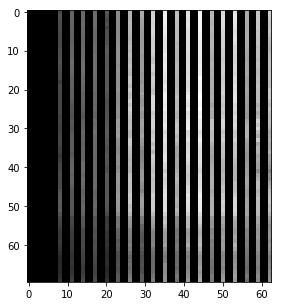

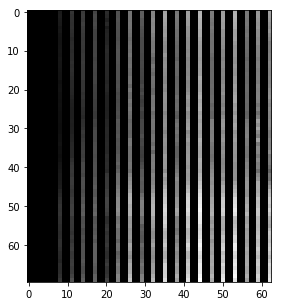

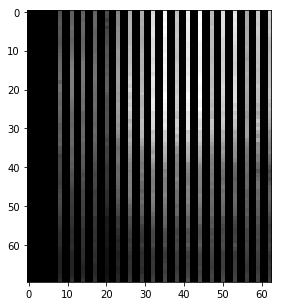

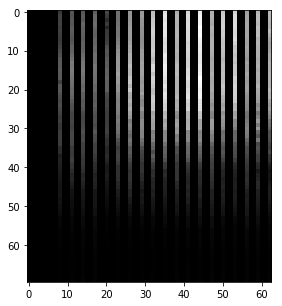

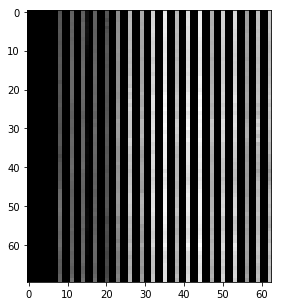

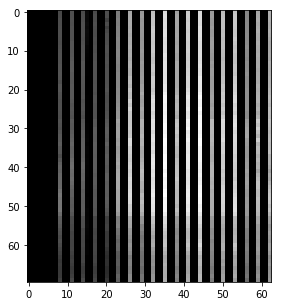

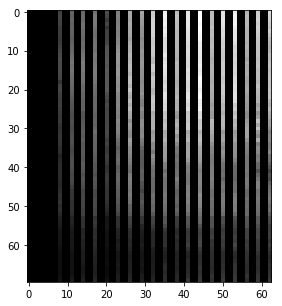

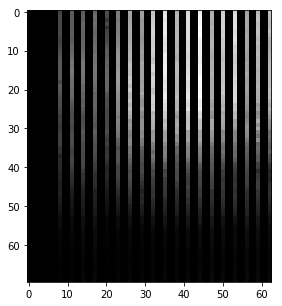

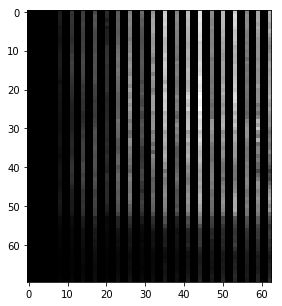

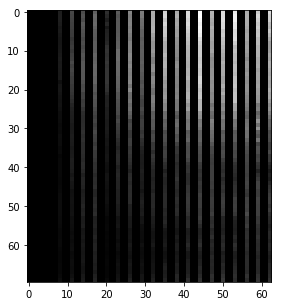

In [13]:
#Sample from distribution
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [sl, 63]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(5,5))
    plt.axis('on')
    plt.imshow(img, cmap='gray')

** Use the z embedding **

In [14]:
location = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/VAE_embedding/z_' + str(n_latent)
np.save(location, z) 
location = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/VAE_embedding/z_test_' + str(n_latent)
np.save(location, z_test) 

In [15]:
#location = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/VAE_embedding/true_labels' 
#location = '/home/nathan/Documents/FYP_code/LSTM1_guillermo/VAE_embedding/test_labels' 

#A = true_labels
#A = train_labels
#train_labels = np.asarray( [ np.where(r==1)[0][0] for r in A ], dtype=np.int64) #one hot to action number
#np.save(location, train_labels)

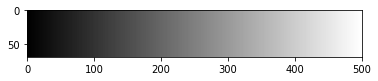

In [16]:
a = np.arange(0,500)
b = np.array([a,]*70)

plt.imshow(b, cmap='gray')


In [17]:
np.max(b)

499